# EDA placeholder

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os
print(os.getcwd()) 

c:\Users\ferna\Desktop\EDA_Dropshipping\EDA_Dropshipping\EDA-Amazon\src\notebooks


In [10]:

amazon = pd.read_csv('../data/amazon.csv')

# Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(amazon.describe())

print("\n" + "="*50 + "\n")

# Ver los nombres de las columnas
print("Columnas disponibles:")
print(amazon.columns.tolist())


# Verificar valores nulos
print("Valores nulos por columna:")
print(amazon.isnull().sum())

# Opción 1: Ver los nombres de las columnas
amazon.columns

Estadísticas descriptivas:
        product_id                                       product_name  \
count         1465                                               1465   
unique        1351                                               1337   
top     B08WRWPM22  Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...   
freq             3                                                  5   

                                                 category discounted_price  \
count                                                1465             1465   
unique                                                211              550   
top     Computers&Accessories|Accessories&Peripherals|...             ₹199   
freq                                                  233               53   

       actual_price discount_percentage rating rating_count  \
count          1465                1465   1465         1463   
unique          449                  92     28         1143   
top            ₹999        

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

In [11]:
amazon.head(20)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...
5,B08Y1TFSP6,pTron Solero TB301 3A Type-C Data and Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹149,"₹1,000",85%,3.9,"24,871",Fast Charging & Data Sync: Solero TB301 Type-C...,"AEQ2YMXSZWEOHK2EHTNLOS56YTZQ,AGRVINWECNY7323CW...","Jayesh,Rajesh k.,Soopy,amazon customer,Aman,Sh...","R7S8ANNSDPR40,R3CLZFLHVJU26P,RFF7U7MPQFUGR,R1M...","It's pretty good,Average quality,very good and...","It's a good product.,Like,Very good item stron...",https://m.media-amazon.com/images/I/31wOPjcSxl...,https://www.amazon.in/Solero-TB301-Charging-48...
6,B08WRWPM22,"boAt Micro USB 55 Tangle-free, Sturdy Micro US...",Computers&Accessories|Accessories&Peripherals|...,₹176.63,₹499,65%,4.1,"15,188",It Ensures High Speed Transmission And Chargin...,"AG7C6DAADCTRQJG2BRS3RIKDT52Q,AFU7BOMPVJ7Q3TTA4...","Vivek kumar,Amazon Customer,SARTHAK,Chiranjeev...","R8E73K2KWJRDS,RSD0JTIIWQQL8,R64CRSTE9SLW1,R2FR...","Long durable.,good,Does not charge Lenovo m8 t...",Build quality is good and it is comes with 2 y...,https://m.media-amazon.com/images/W/WEBP_4

In [5]:
amazon_exploded = amazon.assign(category=amazon["category"].str.split("|")).explode("category")
amazon_exploded["category"] = amazon_exploded["category"].str.strip()

amazon_exploded["category"].nunique()


317

In [6]:
amazon_exploded["category"].value_counts().head(20)

category
Electronics                   526
Computers&Accessories         453
Home&Kitchen                  448
Accessories&Peripherals       381
Kitchen&HomeAppliances        308
Cables                        267
Cables&Accessories            240
USBCables                     233
SmallKitchenAppliances        181
HomeTheater,TV&Video          162
Mobiles&Accessories           161
Heating,Cooling&AirQuality    116
Accessories                   111
MobileAccessories              84
Vacuum,Cleaning&Ironing        82
Smartphones&BasicMobiles       77
SmartWatches                   76
WearableTechnology             76
Televisions                    69
Smartphones                    68
Name: count, dtype: int64

                  category  num_productos
0              Electronics            526
1    Computers&Accessories            453
2             Home&Kitchen            448
3  Accessories&Peripherals            381
4   Kitchen&HomeAppliances            308


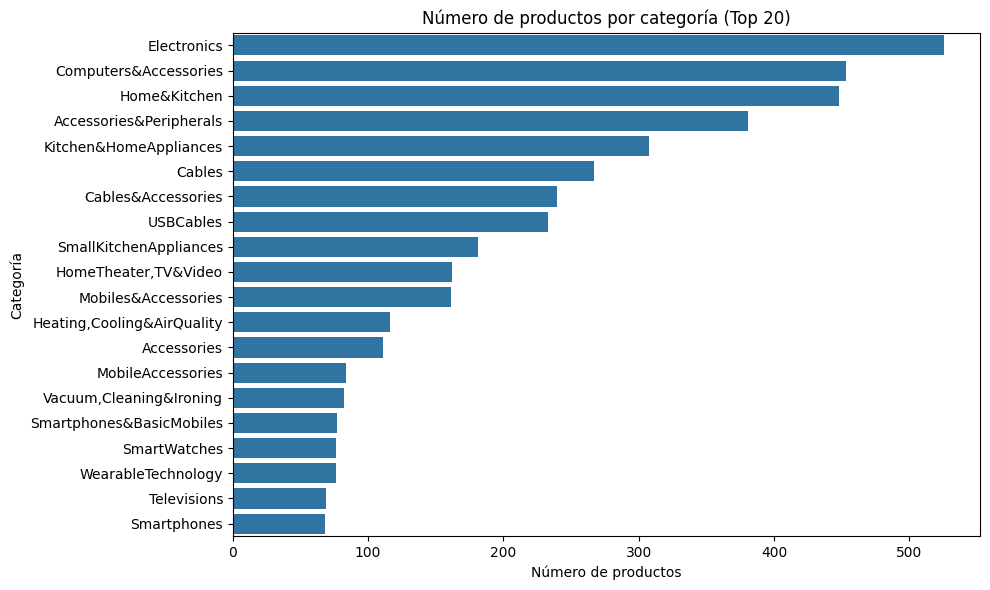

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Conteo con nombres correctos
categorias = (
    amazon_exploded["category"]
      .value_counts()
      .rename_axis("category")        # índice -> columna 'category'
      .reset_index(name="num_productos")  # conteo -> 'num_productos'
)

# 2) Top 20
top20 = categorias.head(20)

# (opcional) comprueba que existen las columnas
print(top20.head())

# 3) Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=top20, x="num_productos", y="category")
plt.title("Número de productos por categoría (Top 20)")
plt.xlabel("Número de productos")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Aseguramos que rating y rating_count sean numéricos

amazon_exploded["rating"] = pd.to_numeric(amazon_exploded["rating"], errors="coerce")
amazon_exploded["rating_count"] = pd.to_numeric(amazon_exploded["rating_count"], errors="coerce")

# --- 1. Agrupar por categoría y calcular métricas ---
nicho = (
    amazon_exploded.groupby("category", as_index=False)
    .agg(
        num_productos=("product_id", "nunique"),
        total_reviews=("rating_count", "sum"),
        rating_medio=("rating", "mean")
    )
)

# --- 2. Calcular reviews por producto ---
nicho["reviews_por_producto"] = nicho["total_reviews"] / nicho["num_productos"]

# --- 3. Eliminar valores extremos o categorías vacías ---
nicho = nicho.dropna(subset=["reviews_por_producto"])
nicho = nicho[nicho["total_reviews"] > 0]

# --- 4. Ordenar para ver los top nichos por eficiencia ---
top_nichos = nicho.sort_values("reviews_por_producto", ascending=False).head(15)

# Ver la tabla resultante (muy útil para revisar)
print(top_nichos[["category", "num_productos", "total_reviews", "reviews_por_producto", "rating_medio"]])


                   category  num_productos  total_reviews  \
1    AVReceivers&Amplifiers              1          897.0   
235              SATACables              1          817.0   
0                 3DGlasses              1          621.0   
76                  Earpads              1          594.0   
269    StovetopEspressoPots              1          590.0   
106          HalogenHeaters              2         1127.0   
316            YogurtMakers              1          557.0   
262             StandMixers              1          534.0   
45           CoffeeGrinders              1          478.0   
78         ElectricGrinders              1          478.0   
110         HandheldVacuums              8         3471.0   
49            ColouredPaper              1          388.0   
233              RotiMakers              1          388.0   
57       Copy&PrintingPaper              1          388.0   
137      InternalHardDrives              1          362.0   

     reviews_por_produc

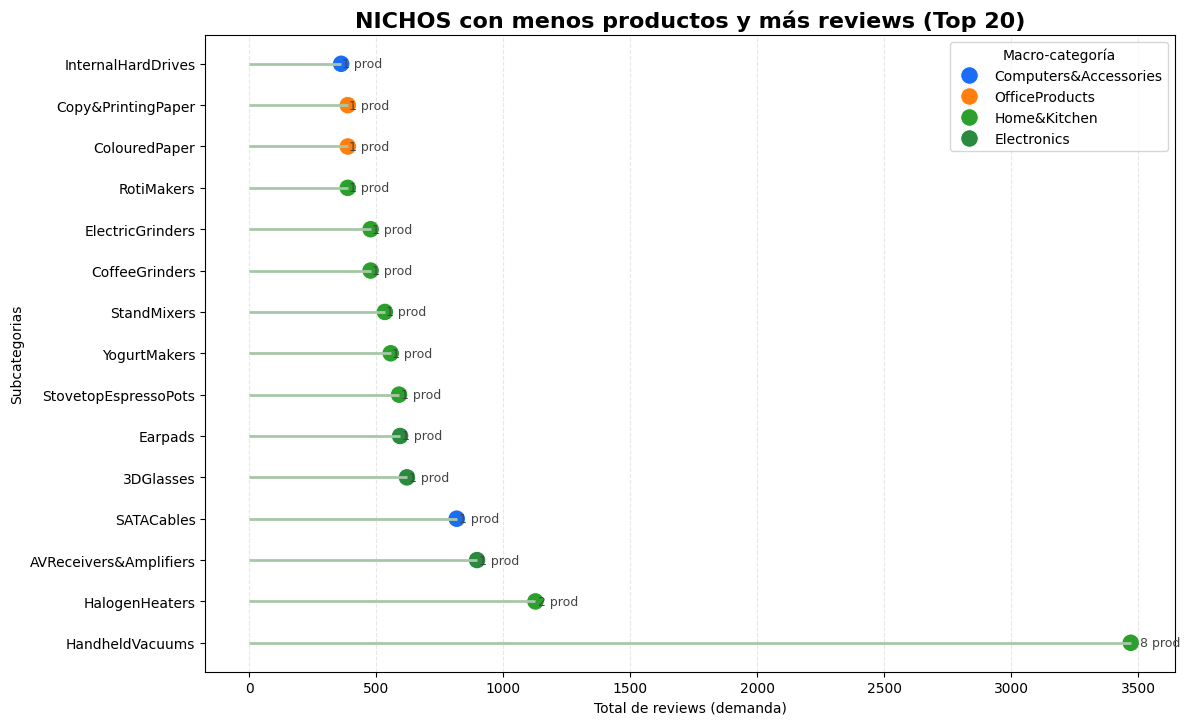

In [17]:
# === Requiere: amazon (rutas con '|'), amazon_exploded, y top20_low_comp del bloque que ya tienes ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Macro-categoría (primer nivel de la ruta) por product_id
routes = amazon[["product_id", "category"]].copy()
routes["macro"] = routes["category"].astype(str).str.split("|").str[0].str.strip()
macro_by_prod = routes[["product_id", "macro"]].dropna()

# 2) Hoja -> macro más frecuente (modo) usando los product_id
leaf_macro = (
    amazon_exploded[["product_id", "category"]]
      .merge(macro_by_prod, on="product_id", how="left")
      .groupby("category")["macro"]
      .agg(lambda s: s.dropna().mode().iat[0] if s.dropna().size else "Unknown")
      .reset_index()
      .rename(columns={"macro": "macro_category"})
)

# 3) Data para el gráfico (Top 20 hojas con poca competencia que ya calculaste)
plot_df = (
    top_nichos.merge(leaf_macro, on="category", how="left")
                  .sort_values("total_reviews", ascending=True)
                  .reset_index(drop=True)
)

# 4) Paleta: resalta Electronics y Computers&Accessories, el resto con una paleta suave
unique_macros = plot_df["macro_category"].fillna("Unknown").unique().tolist()
palette = dict(zip(unique_macros, sns.color_palette("tab10", n_colors=len(unique_macros))))
# Colores fijos para las dos que te interesan
palette["Electronics"] = "#2b8a3e"              # verde
palette["Computers&Accessories"] = "#1b6ef3"    # azul fuerte
palette.setdefault("Unknown", "#999999")

# 5) Lollipop plot
plt.figure(figsize=(12, 8))

# Palos
plt.hlines(y=plot_df["category"], xmin=0, xmax=plot_df["total_reviews"],
           color="#a7c7a9", lw=2)

# Caramelos coloreados por macro-categoría
sns.scatterplot(
    data=plot_df,
    x="total_reviews", y="category",
    hue="macro_category", palette=palette,
    s=160, edgecolor="white", linewidth=0.7
)

# Anota nº de productos al final de cada barra
for _, r in plot_df.iterrows():
    plt.text(r["total_reviews"] * 1.01, r["category"],
             f'{int(r["num_productos"])} prod',
             va="center", fontsize=9, color="#444")

plt.title("NICHOS con menos productos y más reviews (Top 20)",
          fontsize=16, weight="bold")
plt.xlabel("Total de reviews (demanda)")
plt.ylabel("Subcategorias")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.legend(title="Macro-categoría", loc="upper right", frameon=True)
plt.tight_layout()
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()


In [12]:
import pandas as pd
import numpy as np

# Asegura numéricos
amazon_exploded["rating_count"] = pd.to_numeric(amazon_exploded["rating_count"], errors="coerce").fillna(0)

# Agregado por categoría hoja
nicho = (
    amazon_exploded.groupby("category", as_index=False)
    .agg(num_productos=("product_id", "nunique"),
         total_reviews=("rating_count", "sum"))
)
nicho["reviews_por_producto"] = nicho["total_reviews"] / nicho["num_productos"]

# Umbral de "poca competencia" -> bottom 25% por nº de productos
cutoff = nicho["num_productos"].quantile(0.25)
nicho_low_comp = nicho.query("num_productos <= @cutoff").copy()

# Ordena por demanda (y eficiencia)
nicho_low_comp = nicho_low_comp.sort_values(
    ["total_reviews","reviews_por_producto","num_productos"],
    ascending=[False, False, True]
).reset_index(drop=True)

# TOP 20
top20_low_comp = nicho_low_comp.head(20).copy()


In [13]:
# Formato bonito
tbl = top20_low_comp.assign(
    num_productos=top20_low_comp["num_productos"].astype(int),
    total_reviews=top20_low_comp["total_reviews"].astype(int),
    reviews_por_producto=top20_low_comp["reviews_por_producto"].round(1)
)[["category","num_productos","total_reviews","reviews_por_producto"]]

# Styler con gradiente
tbl_style = (
    tbl.style
    .background_gradient(subset=["total_reviews"], cmap="Greens")
    .background_gradient(subset=["reviews_por_producto"], cmap="Greens")
    .format({"num_productos":"{:,.0f}","total_reviews":"{:,.0f}","reviews_por_producto":"{:,.1f}"})
)

display(tbl_style)


,category,num_productos,total_reviews,reviews_por_producto
0,AVReceivers&Amplifiers,1,897,897.0
1,SATACables,1,817,817.0
2,3DGlasses,1,621,621.0
3,Earpads,1,594,594.0
4,StovetopEspressoPots,1,590,590.0
5,YogurtMakers,1,557,557.0
6,StandMixers,1,534,534.0
7,CoffeeGrinders,1,478,478.0
8,ElectricGrinders,1,478,478.0
9,ColouredPaper,1,388,388.0


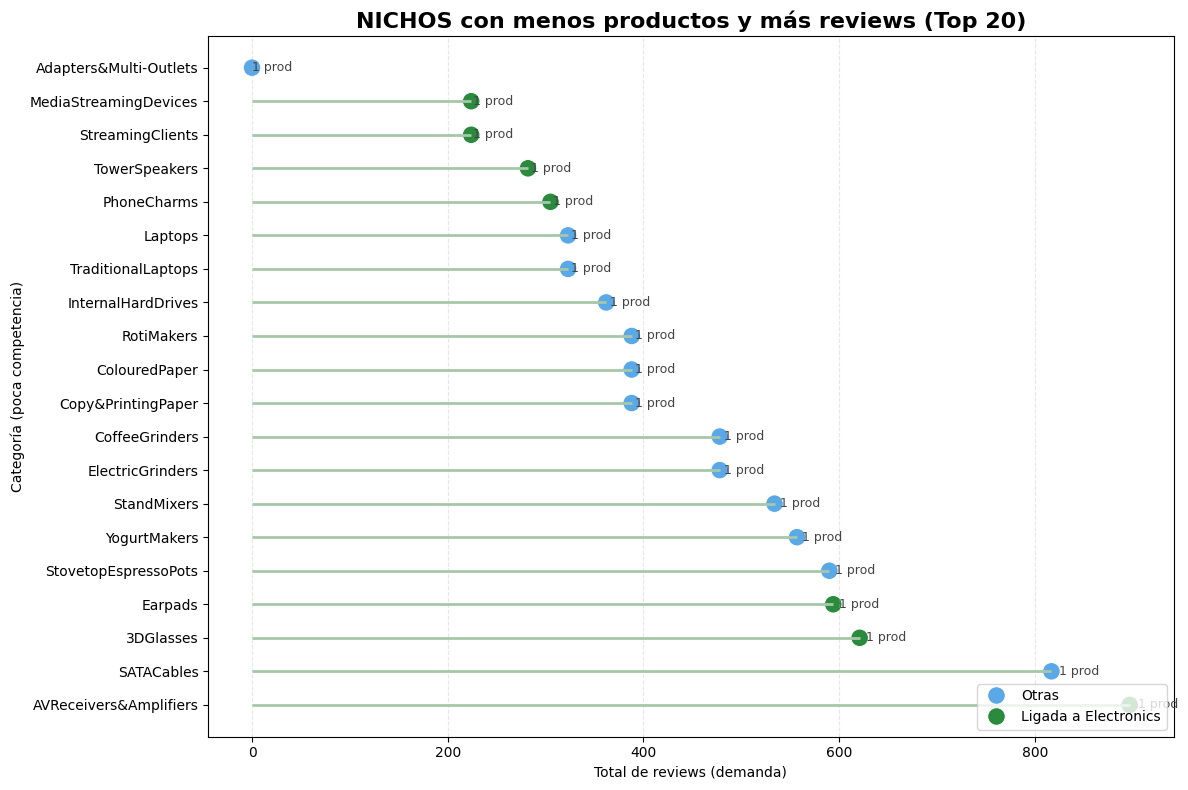

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- (Opcional) marcar si la categoría está ligada a Electronics ----------
# Creamos un flag por producto a partir del DF original "amazon" con categorías crudas
is_elec_by_prod = (
    amazon.assign(_is_elec=amazon["category"].astype(str).str.contains("Electronics", case=False, na=False))
    .groupby("product_id", as_index=False)["_is_elec"].max()
)

# Calculamos % de productos "Electronics" dentro de cada categoría hoja
elec_share = (
    amazon_exploded.merge(is_elec_by_prod, on="product_id", how="left")
    .groupby("category", as_index=False)["_is_elec"].mean()
    .rename(columns={"_is_elec":"share_electronics"})
)

plot_df = (
    top20_low_comp.merge(elec_share, on="category", how="left")
    .assign(tag=lambda d: np.where(d["share_electronics"].fillna(0)>=0.5, "Ligada a Electronics","Otras"))
)

# ---------- Lollipop plot ----------
plot_df = plot_df.sort_values("total_reviews", ascending=True)  # para horizontal de abajo a arriba

plt.figure(figsize=(12,8))
# "palos"
plt.hlines(y=plot_df["category"], xmin=0, xmax=plot_df["total_reviews"], color="#a7c7a9", lw=2)
# "caramelos" (círculos)
sns.scatterplot(
    data=plot_df,
    x="total_reviews", y="category",
    hue="tag", palette={"Ligada a Electronics":"#2b8a3e","Otras":"#5aa9e6"},
    s=160, edgecolor="white", linewidth=0.7
)

# Etiquetas con nº de productos al final de la barra
for _, r in plot_df.iterrows():
    plt.text(r["total_reviews"]*1.01, r["category"], f'{int(r["num_productos"])} prod',
             va="center", fontsize=9, color="#444")

plt.title("NICHOS con menos productos y más reviews (Top 20)", fontsize=16, weight="bold")
plt.xlabel("Total de reviews (demanda)")
plt.ylabel("Categoría (poca competencia)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.legend(title="", loc="lower right")
plt.tight_layout()
plt.show()


C:\Users\ferna\AppData\Local\Temp\ipykernel_21132\3054714868.py:133: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=(0,0,1,0.93))
c:\Users\ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


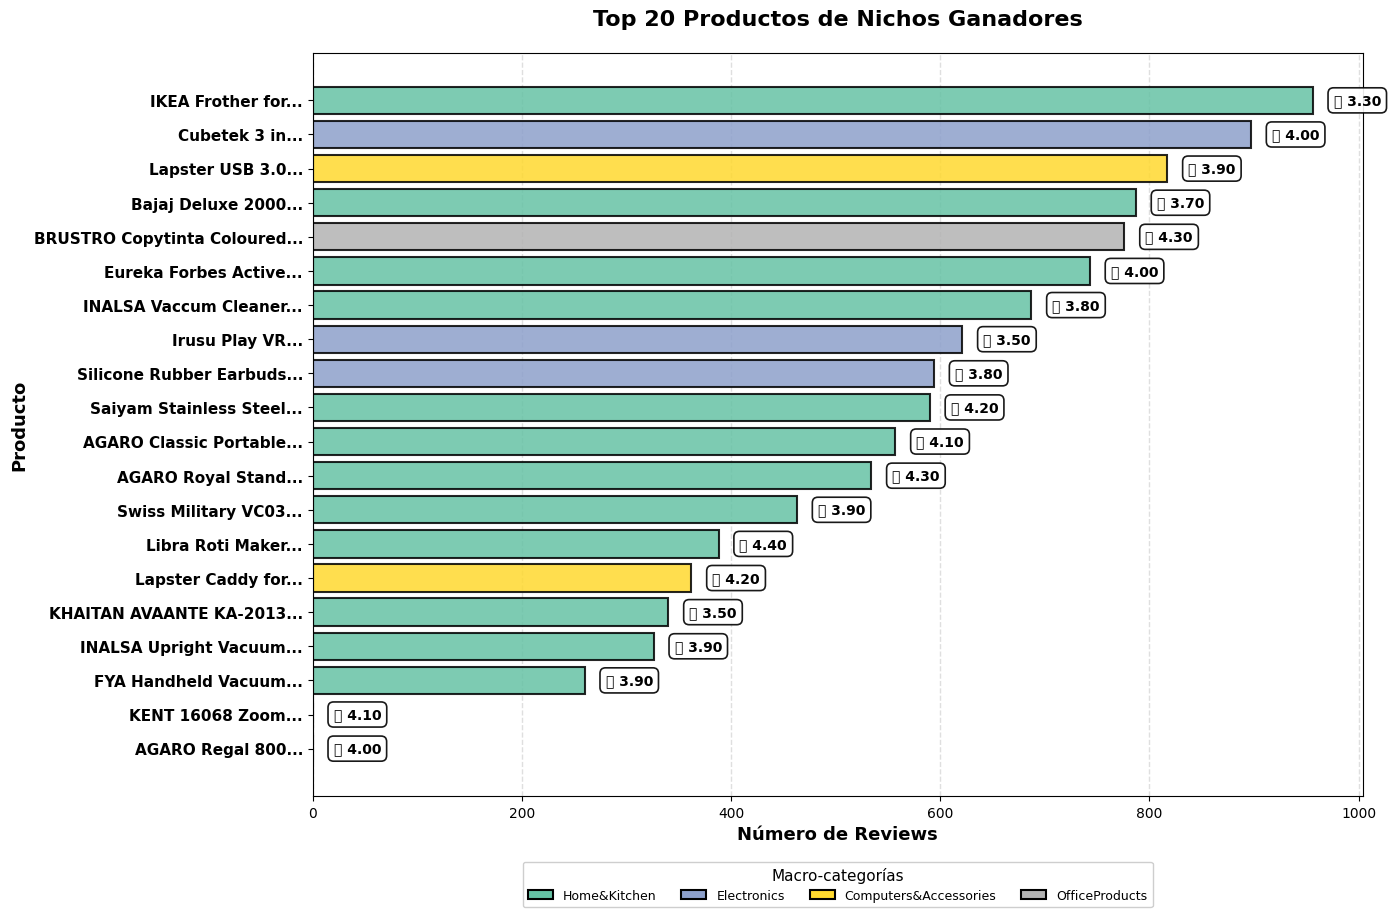

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 1) Elegimos las categorías ganadoras ----------
cats_ganadoras = top_nichos["category"].tolist()

# ---------- 2) Nivel producto dentro de esas categorías ----------
dfp = amazon_exploded[amazon_exploded["category"].isin(cats_ganadoras)].copy()
dfp["rating"] = pd.to_numeric(dfp["rating"], errors="coerce")
dfp["rating_count"] = pd.to_numeric(dfp["rating_count"], errors="coerce").fillna(0)

prod = (dfp.groupby(["product_id","product_name"], as_index=False)
          .agg(
              categoria=("category","first"),
              total_reviews=("rating_count","sum"),
              rating_medio=("rating","mean")
          ))

prod = prod.dropna(subset=["rating_medio"])

# ---------- 2.1) Añadir MACRO-CATEGORÍA (primer nivel de la ruta en 'amazon') ----------
rutas = amazon[["product_id","category"]].copy()
rutas["macro"] = rutas["category"].astype(str).str.split("|").str[0].str.strip()
macro_by_prod = rutas[["product_id","macro"]].dropna()

prod = prod.merge(macro_by_prod, on="product_id", how="left")
prod["macro"] = prod["macro"].fillna("Unknown")

# Top 20 por reviews
top20_prods = prod.sort_values("total_reviews", ascending=False).head(20).copy()

# Etiqueta corta: solo 3 primeras palabras
top20_prods["nombre_corto"] = top20_prods["product_name"].apply(
    lambda x: " ".join(str(x).split()[:3]) + "..."
)

# (Opcional) incluir la macro en la etiqueta de la izquierda para más contexto
SHOW_MACRO_IN_LABELS = False
if SHOW_MACRO_IN_LABELS:
    top20_prods["nombre_corto"] = top20_prods["nombre_corto"] + " · " + top20_prods["macro"]

# ---------- 3) Crear mapa de colores por MACRO-CATEGORÍA ----------
macros_unicas = top20_prods["macro"].unique()
colores_macros = plt.cm.Set2(np.linspace(0, 1, len(macros_unicas)))
mapa_colores = dict(zip(macros_unicas, colores_macros))

# Asignar color a cada producto según su macro
top20_prods["color"] = top20_prods["macro"].map(mapa_colores)

# ---------- 4) Gráfico de barras horizontales ----------
fig, ax = plt.subplots(figsize=(14, 10))

# Ordenar de menor a mayor para que el más popular quede arriba
top20_prods_sorted = top20_prods.sort_values("total_reviews", ascending=True)

# Barras horizontales con colores por MACRO
bars = ax.barh(
    range(len(top20_prods_sorted)),
    top20_prods_sorted["total_reviews"],
    color=top20_prods_sorted["color"].tolist(),
    edgecolor="black",
    linewidth=1.5,
    alpha=0.85
)

# Nombres de productos en el eje Y
ax.set_yticks(range(len(top20_prods_sorted)))
ax.set_yticklabels(top20_prods_sorted["nombre_corto"], fontsize=11, weight="semibold")

# Mostrar número de estrellas AL FINAL de cada barra
for i, (_, row) in enumerate(top20_prods_sorted.iterrows()):
    ax.text(
        row["total_reviews"] + 20,
        i,
        f"⭐ {row['rating_medio']:.2f}",
        va="center",
        fontsize=10,
        weight="bold",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white",
                  edgecolor="black", linewidth=1.2, alpha=0.9)
    )

# Títulos y etiquetas
ax.set_xlabel("Número de Reviews", fontsize=13, weight="bold")
ax.set_ylabel("Producto", fontsize=13, weight="bold")
ax.set_title(
    "Top 20 Productos de Nichos Ganadores",
    fontsize=16, weight="bold", pad=20
)

# Grid
ax.grid(axis="x", linestyle="--", alpha=0.4, linewidth=1)
ax.set_axisbelow(True)

# ---------- Leyenda con MACRO-CATEGORÍAS ----------
from matplotlib.patches import Rectangle
legend_elements = []
for macro, color in mapa_colores.items():
    legend_elements.append(
        Rectangle((0,0), 1, 1, facecolor=color, edgecolor="black",
                  linewidth=1.5, label=macro)
    )

# Coloca la leyenda arriba, centrada, fuera del área del gráfico

leg = ax.get_legend()
if leg is not None:
    leg.remove()

# --- CREA la leyenda abajo, centrada, en columnas ---
from matplotlib.patches import Rectangle
legend_elements = []
for macro, color in mapa_colores.items():
    legend_elements.append(
        Rectangle((0,0), 1, 1, facecolor=color, edgecolor="black",
                  linewidth=1.5, label=macro)
    )

ax.legend(
    handles=legend_elements,
    title="Macro-categorías",
    loc="upper center",            # base
    bbox_to_anchor=(0.5, -0.08),   # ⬅️ abajo (negativo saca fuera del plot)
    ncol=min(4, len(legend_elements)),
    fontsize=9,
    title_fontsize=11,
    framealpha=0.95
)



plt.tight_layout(rect=(0,0,1,0.93))
plt.show()


In [ ]:
# Asegúrate de tener el nombre correcto de la columna de links:
col_link = "product_link"  # cámbialo si se llama distinto

# Filtramos solo los 3 primeros productos
top3_ids = top20_prods.head(3)["product_id"]

# Buscamos esos productos en el dataset original y sacamos sus links
top3_links = amazon_exploded[
    amazon_exploded["product_id"].isin(top3_ids)
][["product_id", "product_name", col_link]].drop_duplicates().reset_index(drop=True)

# Mostramos el resultado
pd.set_option("display.max_colwidth", None)
display(top3_links)



,product_id,product_name,product_link
0,B0978V2CP6,"Cubetek 3 in 1 LCD Display V5.0 Bluetooth Transmitter Receiver, Bypass Audio Adapter with Aux, Optical, Dual Link Support for TV, Home Stereo, PC, Headphones, Speakers, Model: CB-BT27",https://www.amazon.in/Bluetooth-Transmitter-Receiver-Headphones-Speakers/dp/B0978V2CP6/ref=sr_1_385?qid=1672909144&s=electronics&sr=1-385
1,B08PFSZ7FH,STRIFF Laptop Stand Adjustable Laptop Computer Stand Multi-Angle Stand Phone Stand Portable Foldable Laptop Riser Notebook Holder Stand Compatible for 9 to 15.6” Laptops Black(Black),https://www.amazon.in/STRIFF-Adjustable-Computer-Multi-Angle-Compatible/dp/B08PFSZ7FH/ref=sr_1_189?qid=1672903004&s=computers&sr=1-189
2,B0B4KPCBSH,IKEA Frother for Milk,https://www.amazon.in/Ikea-45454-IKEA-Frother-Milk/dp/B0B4KPCBSH/ref=sr_1_119_mod_primary_new?qid=1672923596&s=kitchen&sbo=RZvfv%2F%2FHxDF%2BO5021pAnSA%3D%3D&sr=1-119


In [ ]:
# Reemplaza el texto entre comillas por el nombre o parte del nombre del producto
nombre_busqueda = "Irusu Play VR"   # por ejemplo, las gafas 3D

# Buscamos insensible a mayúsculas/minúsculas
resultado = amazon_exploded[
    amazon_exploded["product_name"].str.contains(nombre_busqueda, case=False, na=False)
][["product_id", "product_name", "category", "rating", "rating_count", "product_link"]]

pd.set_option("display.max_colwidth", None)
display(resultado)


,product_id,product_name,category,rating,rating_count,product_link
312,B097JVLW3L,Irusu Play VR Plus Virtual Reality Headset with Headphones for Gaming (Black),Electronics,3.5,621.0,https://www.amazon.in/Virtual-Reality-Headset-Headphones-Gaming/dp/B097JVLW3L/ref=sr_1_479?qid=1672909147&s=electronics&sr=1-479
312,B097JVLW3L,Irusu Play VR Plus Virtual Reality Headset with Headphones for Gaming (Black),"HomeTheater,TV&Video",3.5,621.0,https://www.amazon.in/Virtual-Reality-Headset-Headphones-Gaming/dp/B097JVLW3L/ref=sr_1_479?qid=1672909147&s=electronics&sr=1-479
312,B097JVLW3L,Irusu Play VR Plus Virtual Reality Headset with Headphones for Gaming (Black),Accessories,3.5,621.0,https://www.amazon.in/Virtual-Reality-Headset-Headphones-Gaming/dp/B097JVLW3L/ref=sr_1_479?qid=1672909147&s=electronics&sr=1-479
312,B097JVLW3L,Irusu Play VR Plus Virtual Reality Headset with Headphones for Gaming (Black),3DGlasses,3.5,621.0,https://www.amazon.in/Virtual-Reality-Headset-Headphones-Gaming/dp/B097JVLW3L/ref=sr_1_479?qid=1672909147&s=electronics&sr=1-479


In [ ]:
total_productos = amazon["product_id"].nunique()
print(total_productos)


1351


In [ ]:
# Cálculo de categorías y subcategorías (L1, L2, leaf) con conteos
import pandas as pd
import numpy as np

# --- Entrada esperada: DataFrame 'amazon' con columnas ['product_id', 'category'] donde 'category' es ruta "A|B|C|..." ---

# 1) Normaliza y separa ruta en niveles
routes = amazon[["product_id", "category"]].copy()
routes["category"] = routes["category"].astype(str).str.strip()
routes["parts"] = routes["category"].str.split("|")

# Crea niveles L1..L5 (amplía si necesitas más)
max_levels = 5
for i in range(max_levels):
    routes[f"L{i+1}"] = routes["parts"].apply(
        lambda xs: xs[i].strip() if isinstance(xs, list) and len(xs) > i and isinstance(xs[i], str) else np.nan
    )

# Leaf = último nivel no nulo
def last_non_nan(row):
    for i in range(max_levels, 0, -1):
        val = row[f"L{i}"]
        if pd.notna(val) and str(val).strip() != "":
            return val
    return np.nan
routes["leaf"] = routes.apply(last_non_nan, axis=1)

# 2) Conteos por nivel
# Macro (L1)
macro_count = (
    routes.dropna(subset=["L1"])
          .groupby("L1", as_index=False)["product_id"]
          .nunique()
          .rename(columns={"L1":"macro_L1","product_id":"n_productos"})
          .sort_values("n_productos", ascending=False, ignore_index=True)
)

# Subcategorías L1 -> L2
sub_count = (
    routes.dropna(subset=["L1","L2"])
          .groupby(["L1","L2"], as_index=False)["product_id"]
          .nunique()
          .rename(columns={"L1":"macro_L1","L2":"sub_L2","product_id":"n_productos"})
          .sort_values(["macro_L1","n_productos"], ascending=[True, False], ignore_index=True)
)

# Categorías hoja (leaf)
leaf_count = (
    routes.dropna(subset=["leaf"])
          .groupby("leaf", as_index=False)["product_id"]
          .nunique()
          .rename(columns={"product_id":"n_productos"})
          .sort_values("n_productos", ascending=False, ignore_index=True)
)

# 3) Enumeración estable de todas las hojas (orden alfabético)
leaf_enum = (
    leaf_count.sort_values("leaf", kind="mergesort", ignore_index=True)
              .reset_index()
              .rename(columns={"index":"pos"})
)
leaf_enum["pos"] = leaf_enum["pos"] + 1  # empieza en 1

# 4) (Opcional) imprime totales rápidos
print(f"Total macro (L1): {macro_count['macro_L1'].nunique()}")
print(f"Total subcategorías L1->L2: {len(sub_count)}")
print(f"Total categorías hoja (leaf): {leaf_count['leaf'].nunique()}")

# 5) Muestra primeras filas (puedes comentar estas líneas si no quieres imprimir)
display(macro_count.head(20))
display(sub_count.head(20))
display(leaf_count.head(20))
display(leaf_enum.head(20))


Total macro (L1): 9
Total subcategorías L1->L2: 29
Total categorías hoja (leaf): 195


,macro_L1,n_productos
0,Electronics,490
1,Home&Kitchen,448
2,Computers&Accessories,375
3,OfficeProducts,31
4,MusicalInstruments,2
5,HomeImprovement,2
6,Car&Motorbike,1
7,Health&PersonalCare,1
8,Toys&Games,1


,macro_L1,sub_L2,n_productos
0,Car&Motorbike,CarAccessories,1
1,Computers&Accessories,Accessories&Peripherals,307
2,Computers&Accessories,NetworkingDevices,30
3,Computers&Accessories,ExternalDevices&DataStorage,18
4,Computers&Accessories,"Printers,Inks&Accessories",11
5,Computers&Accessories,Components,5
6,Computers&Accessories,Monitors,2
7,Computers&Accessories,Laptops,1
8,Computers&Accessories,Tablets,1
9,Electronics,"HomeTheater,TV&Video",156


,leaf,n_productos
0,USBCables,161
1,Smartphones,68
2,SmartWatches,62
3,SmartTelevisions,60
4,In-Ear,51
5,RemoteControls,49
6,Irons,36
7,MixerGrinders,27
8,Mice,24
9,InstantWaterHeaters,23


,pos,leaf,n_productos
0,1,3DGlasses,1
1,2,AVReceivers&Amplifiers,1
2,3,Adapters,2
3,4,Adapters&Multi-Outlets,1
4,5,AirFryers,5
5,6,AirPurifiers&Ionizers,1
6,7,AutomobileChargers,4
7,8,Basic,1
8,9,BasicCases,4
9,10,BasicMobiles,9


C:\Users\ferna\AppData\Local\Temp\ipykernel_21132\436900977.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk_with_other, k=3)


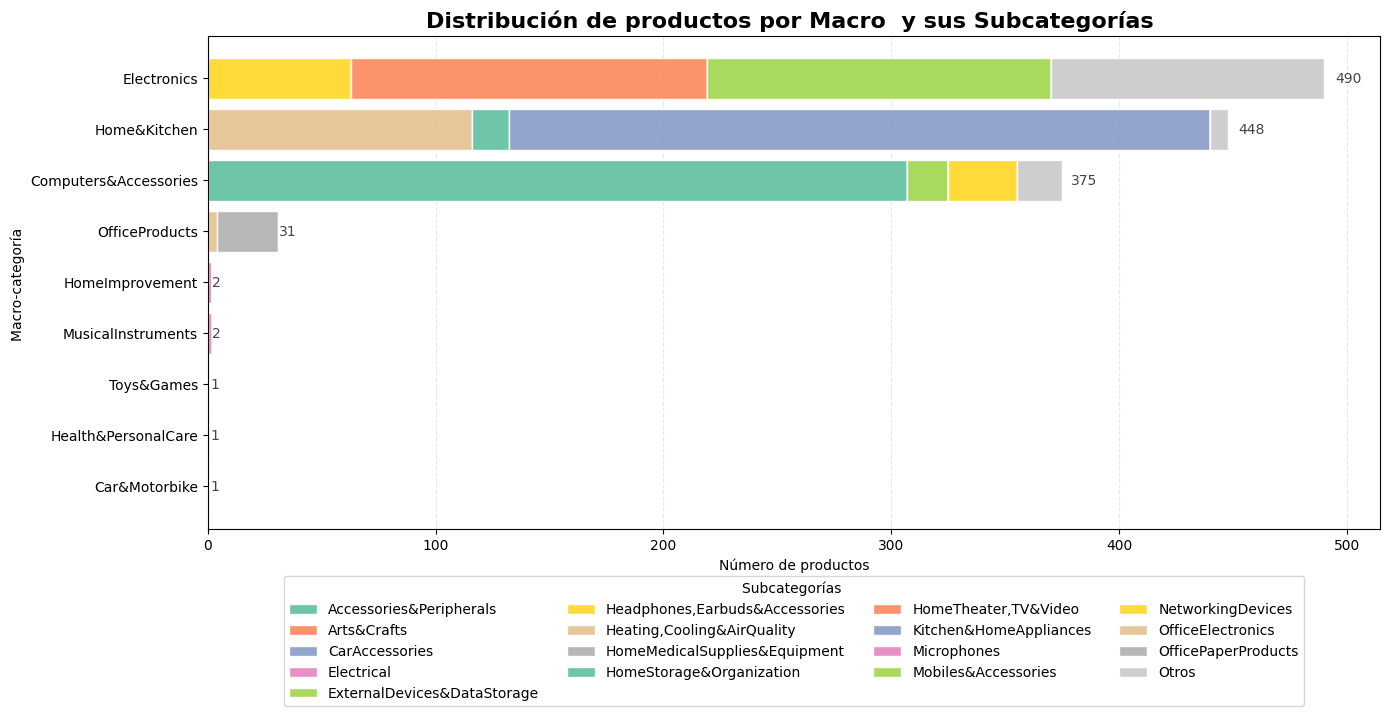

In [20]:
# ================== GRAFICAZO: Macro (L1) con reparto de Top-3 subcategorías (L2) ==================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Entrada: amazon con columnas ['product_id','category'] donde 'category' es ruta "Macro|Sub|...".
routes = amazon[["product_id","category"]].copy()
routes["category"] = routes["category"].astype(str).str.strip()
routes["parts"] = routes["category"].str.split("|")

# Niveles L1 (macro) y L2 (sub)
routes["L1"] = routes["parts"].apply(lambda xs: xs[0].strip() if isinstance(xs, list) and len(xs)>0 else np.nan)
routes["L2"] = routes["parts"].apply(lambda xs: xs[1].strip() if isinstance(xs, list) and len(xs)>1 else "Otros")

# --- Conteos por L1 y L1->L2 ---
macro = (routes.dropna(subset=["L1"])
                .groupby("L1", as_index=False)["product_id"].nunique()
                .rename(columns={"product_id":"n_prod_macro"}))

subs = (routes.dropna(subset=["L1"])
               .groupby(["L1","L2"], as_index=False)["product_id"].nunique()
               .rename(columns={"product_id":"n_prod_sub"}))

# --- Para cada macro, quedarnos con Top-3 subcategorías y agrupar el resto en "Otros" ---
def topk_with_other(df, k=3):
    df = df.sort_values("n_prod_sub", ascending=False)
    if len(df) <= k:
        return df
    top = df.head(k).copy()
    other = pd.DataFrame({
        "L1":[df["L1"].iloc[0]],
        "L2":["Otros"],
        "n_prod_sub":[df["n_prod_sub"].iloc[k:].sum()]
    })
    return pd.concat([top, other], ignore_index=True)

stacked = (subs.groupby("L1", group_keys=False)
                .apply(topk_with_other, k=3)
                .reset_index(drop=True))

# --- Ordenar macros por tamaño total ---
stacked_tot = stacked.groupby("L1", as_index=False)["n_prod_sub"].sum().rename(columns={"n_prod_sub":"n_total"})
stacked = stacked.merge(stacked_tot, on="L1", how="left")

# Selecciona las Top-N macros a mostrar
TOP_MACROS = 10
stacked = (stacked.sort_values(["n_total","n_prod_sub"], ascending=[False, False])
                  .groupby("L1", as_index=False)
                  .head(4))  # Top3 + 'Otros' = hasta 4 segmentos por macro
top_macros = stacked["L1"].drop_duplicates().head(TOP_MACROS)
stacked = stacked[stacked["L1"].isin(top_macros)]

# Recalcula orden final y pivota a formato ancho para apilar
order_macros = (stacked.groupby("L1")["n_prod_sub"].sum()
                        .sort_values(ascending=True)  # de menor a mayor para que la barra más grande quede arriba al final
                        .index.tolist())
stacked["L2"] = stacked["L2"].astype(str)

wide = (stacked.pivot_table(index="L1", columns="L2", values="n_prod_sub", aggfunc="sum", fill_value=0)
               .loc[order_macros])

# --- Colores (Top-3 + Otros) ---
subs_cols = [c for c in wide.columns if c!="Otros"]
palette = sns.color_palette("Set2", n_colors=len(subs_cols))
colors_map = dict(zip(subs_cols, palette))
colors_map["Otros"] = (0.80, 0.80, 0.80)  # gris suave para Otros

# --- Plot apilado horizontal ---
plt.figure(figsize=(14, 8))
left = np.zeros(len(wide))
ypos = np.arange(len(wide))

for col in subs_cols + (["Otros"] if "Otros" in wide.columns else []):
    vals = wide[col].values
    plt.barh(wide.index, vals, left=left, color=colors_map.get(col, "#cccccc"),
             edgecolor="white", linewidth=1.0, label=col, alpha=0.95)
    left += vals

# Anotar total al final de cada barra
totals = wide.sum(axis=1).astype(int)
for y, (name, total) in enumerate(totals.items()):
    plt.text(total*1.01, y, f"{total:,}".replace(",", "."), va="center", fontsize=10, color="#444")

plt.title("Distribución de productos por Macro  y sus Subcategorías ", fontsize=16, fontweight="bold")
plt.xlabel("Número de productos")
plt.ylabel("Macro-categoría ")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.gca().set_axisbelow(True)

# Leyenda abajo, centrada
handles, labels = plt.gca().get_legend_handles_labels()
# Quita duplicados manteniendo orden
seen, h2, l2 = set(), [], []
for h, lab in zip(handles, labels):
    if lab not in seen:
        seen.add(lab); h2.append(h); l2.append(lab)
plt.legend(h2, l2, title="Subcategorías ", loc="upper center", bbox_to_anchor=(0.5, -0.08),
           ncol=min(4, len(l2)), frameon=True)

plt.tight_layout(rect=(0, 0.06, 1, 0.98))
plt.show()
